<a href="https://colab.research.google.com/github/Saurabhganvir/M5_forecasting_validation/blob/main/M5_accuracy_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()

Saving m5-forecasting-accuracy.zip to m5-forecasting-accuracy.zip


In [4]:
import zipfile
import os
with zipfile.ZipFile("m5-forecasting-accuracy.zip", "r") as zip_ref:
  zip_ref.extractall(".")

#verify extraction
print("Extracted files:")
for file in os.listdir("."):
  print(file)

Extracted files:
.config
m5-forecasting-accuracy.zip
sample_submission.csv
sales_train_evaluation.csv
calendar.csv
sell_prices.csv
sales_train_validation.csv
sample_data


In [5]:
# ================================
# M5 Forecasting Accuracy - EDA (Colab Optimized)
# ================================

# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

# 2. Load Data (only once, with efficient dtypes)
calendar = pd.read_csv("calendar.csv")
prices   = pd.read_csv("sell_prices.csv")
sales    = pd.read_csv("sales_train_evaluation.csv")

# Optimize dtypes
for c in sales.columns:
    if c.startswith("d_"):
        sales[c] = sales[c].astype("int16")
prices["sell_price"] = prices["sell_price"].astype("float32")

# Convert calendar to datetime and filter out 2011 & 2012
calendar["date"] = pd.to_datetime(calendar["date"])
calendar = calendar[calendar["date"].dt.year >= 2013]

# Keep only relevant day columns (from 2013 onwards)
valid_days = set(calendar["d"].unique())
day_cols = [c for c in sales.columns if c in valid_days]

print(f"Keeping {len(day_cols)} day columns out of {sales.filter(like='d_').shape[1]}")


Keeping 1238 day columns out of 1941


Date range: 2013-01-01 00:00:00 to 2016-06-19 00:00:00
Unique events: ['NewYear' 'OrthodoxChristmas' 'MartinLutherKingDay' 'SuperBowl'
 'LentStart' 'ValentinesDay' 'PresidentsDay' 'LentWeek2' 'Purim End'
 'StPatricksDay' 'Easter' 'Pesach End' 'OrthodoxEaster' "Mother's day"
 'MemorialDay' 'NBAFinalsStart' "Father's day" 'NBAFinalsEnd'
 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr' 'LaborDay' 'ColumbusDay'
 'EidAlAdha' 'Halloween' 'VeteransDay' 'Thanksgiving' 'Chanukah End'
 'Christmas' 'Cinco De Mayo']


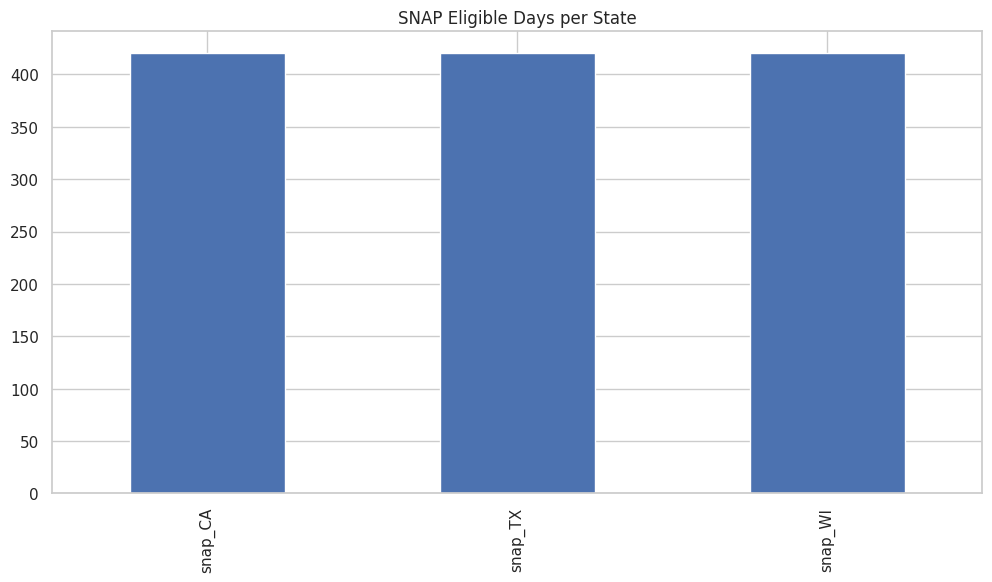

In [6]:
print("Date range:", calendar["date"].min(), "to", calendar["date"].max())
print("Unique events:", calendar["event_name_1"].dropna().unique())

# sns.countplot(x="weekday", data=calendar,
#               order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
# plt.title("Count of Days per Weekday")
# plt.show()

calendar[["snap_CA","snap_TX","snap_WI"]].sum().plot(kind="bar")
plt.title("SNAP Eligible Days per State")
plt.show()


Prices shape after filtering: (5088563, 4)


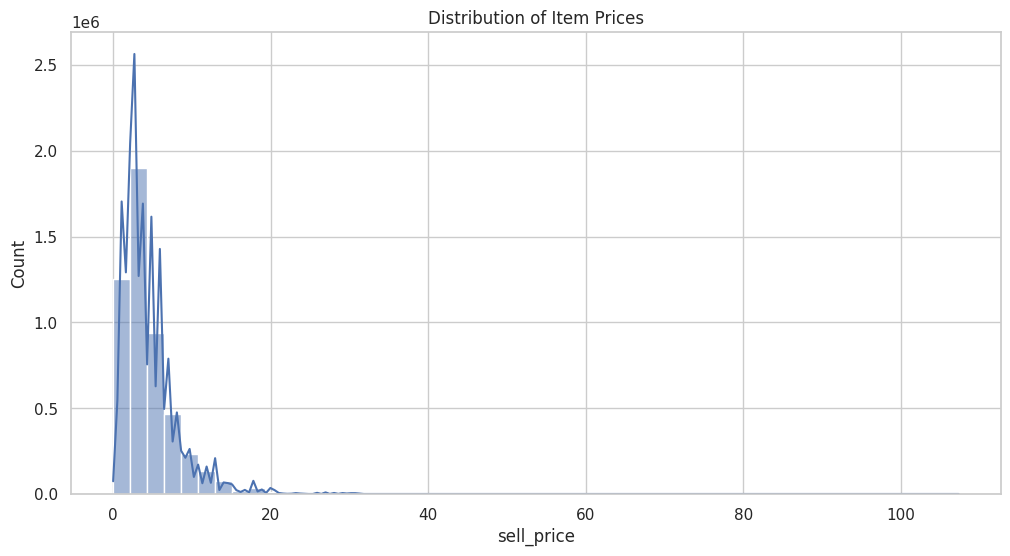

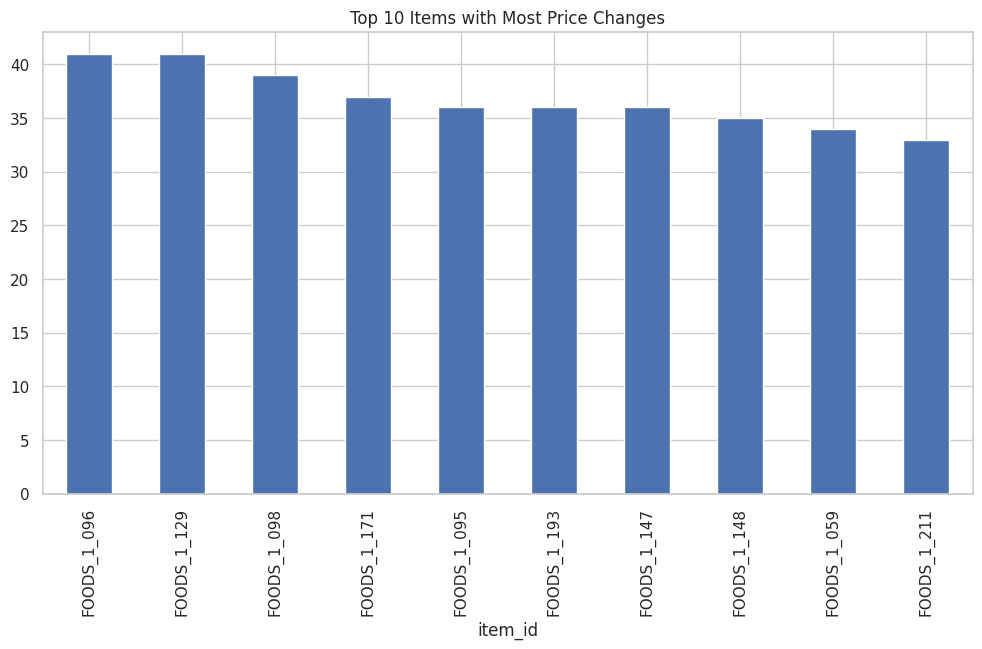

In [7]:
# Reduce size by keeping only 2013 onwards
prices = prices[prices["wm_yr_wk"].isin(calendar["wm_yr_wk"].unique())]

print("Prices shape after filtering:", prices.shape)

sns.histplot(prices["sell_price"], bins=50, kde=True)
plt.title("Distribution of Item Prices")
plt.show()

# Top 10 items with most price changes
item_price_var = prices.groupby("item_id")["sell_price"].nunique().sort_values(ascending=False).head(10)
item_price_var.plot(kind="bar")
plt.title("Top 10 Items with Most Price Changes")
plt.show()


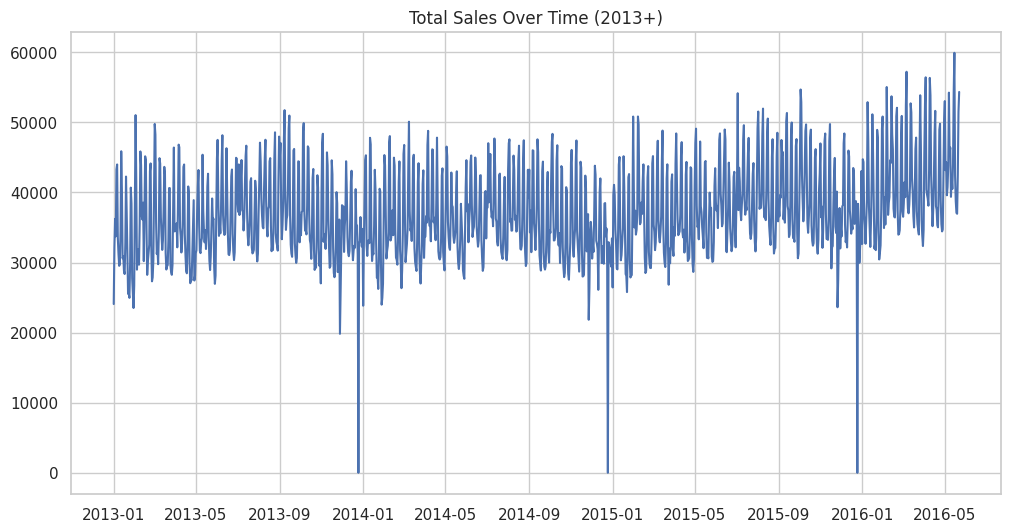

In [8]:
# Aggregate total sales per day directly (no melt)
daily_sales = sales[day_cols].sum().reset_index()
daily_sales.columns = ["d","total_sales"]

# Merge with calendar to get dates
daily_sales = daily_sales.merge(calendar[["d","date"]], on="d", how="left")

# Plot total sales
plt.plot(daily_sales["date"], daily_sales["total_sales"])
plt.title("Total Sales Over Time (2013+)")
plt.show()


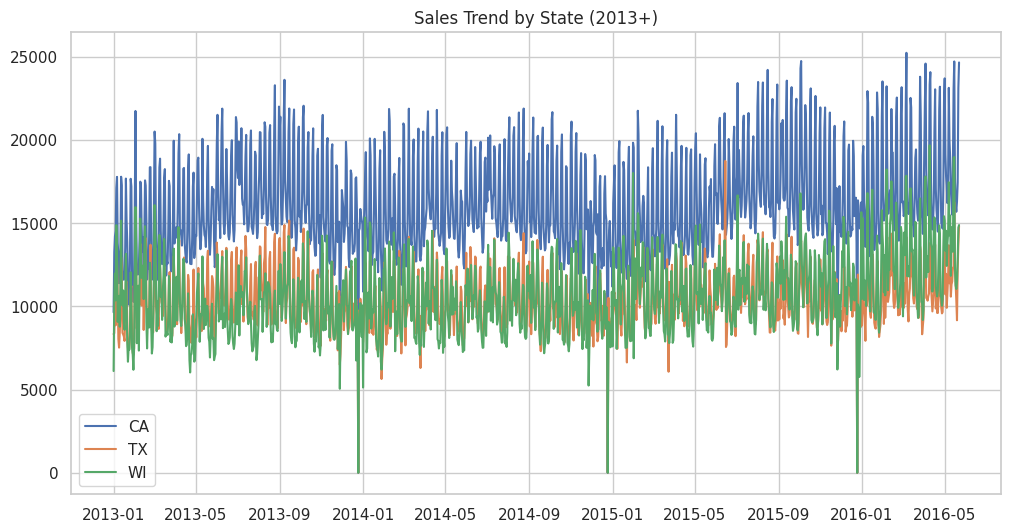

In [9]:
# Sum per state without melting everything
state_sales = {}
for state in sales["state_id"].unique():
    tmp = sales[sales["state_id"]==state]
    totals = tmp[day_cols].sum().reset_index()
    totals.columns = ["d","sales"]
    totals = totals.merge(calendar[["d","date"]], on="d", how="left")
    state_sales[state] = totals

for state, df in state_sales.items():
    plt.plot(df["date"], df["sales"], label=state)
plt.legend()
plt.title("Sales Trend by State (2013+)")
plt.show()


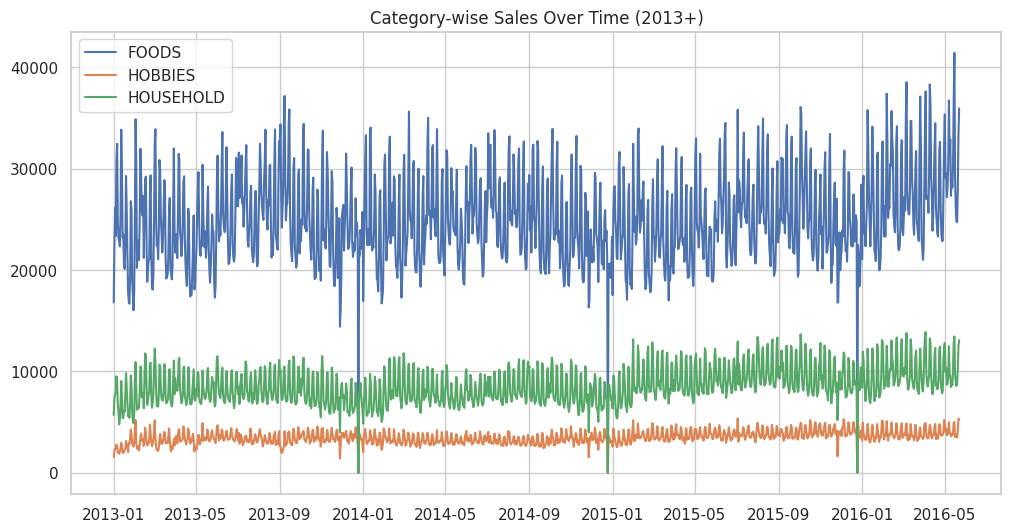

In [10]:
# Aggregate category sales
cat_sales = sales.groupby("cat_id")[day_cols].sum().T.reset_index()
cat_sales = cat_sales.rename(columns={"index":"d"})
cat_sales = cat_sales.merge(calendar[["d","date"]], on="d", how="left")

for cat in cat_sales.drop(columns=["d","date"]).columns:
    plt.plot(cat_sales["date"], cat_sales[cat], label=cat)
plt.legend()
plt.title("Category-wise Sales Over Time (2013+)")
plt.show()


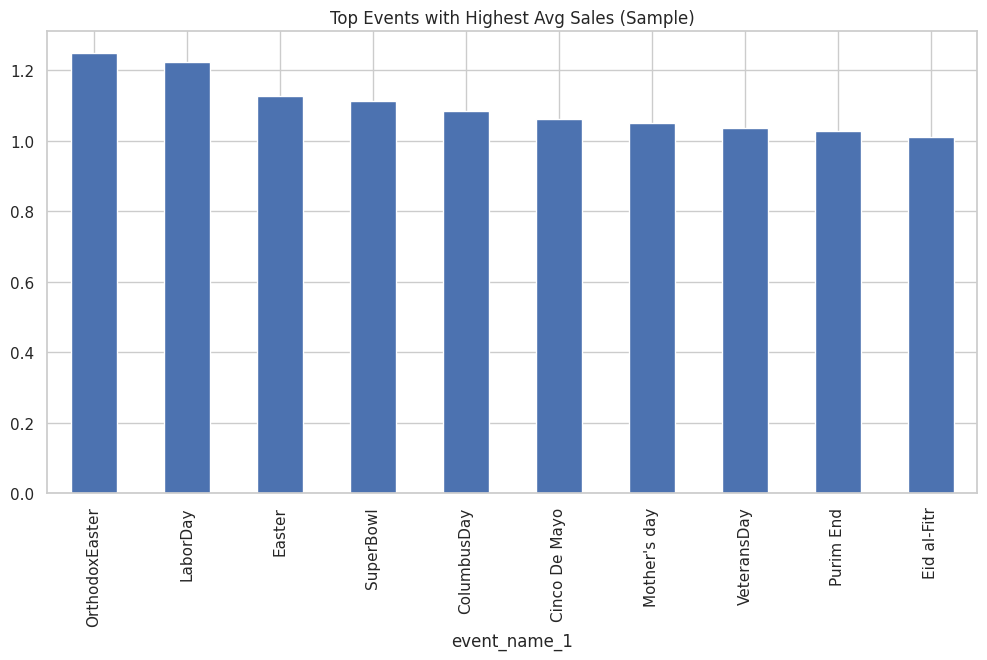

In [11]:
# Use a random sample of items to save memory
sample_ids = sales["id"].sample(200, random_state=42)

sample_sales = sales[sales["id"].isin(sample_ids)]
sample_sales = sample_sales.melt(
    id_vars=["id","item_id","dept_id","cat_id","store_id","state_id"],
    value_vars=day_cols,
    var_name="d", value_name="sales"
)

sample_sales = sample_sales.merge(calendar[["d","date","event_name_1"]], on="d", how="left")

event_sales = sample_sales.groupby("event_name_1")["sales"].mean().dropna().sort_values(ascending=False).head(10)
event_sales.plot(kind="bar")
plt.title("Top Events with Highest Avg Sales (Sample)")
plt.show()


In [12]:
# ================================
# Final EDA Insights Summary
# ================================

print("🔎 Generating EDA Insights Summary...")

# 1. Top categories by total sales
cat_totals = sales.groupby("cat_id")[day_cols].sum().sum(axis=1).sort_values(ascending=False)

# 2. Top departments by total sales
dept_totals = sales.groupby("dept_id")[day_cols].sum().sum(axis=1).sort_values(ascending=False)

# 3. Top events driving sales (sample-based to save memory)
event_means = sample_sales.groupby("event_name_1")["sales"].mean().dropna().sort_values(ascending=False).head(5)

# 4. State-wise average daily sales
state_avg = {state: df["sales"].mean() for state, df in state_sales.items()}

# 5. Zero-sales prevalence (sample-based)
zero_sales_ratio = sample_sales.groupby("id")["sales"].apply(lambda x: (x==0).mean()).mean()

# -------------------------
# Print Human-readable Summary
# -------------------------
print("\n📊 CATEGORY INSIGHTS")
print("Top categories by total sales:")
for cat, val in cat_totals.head(3).items():
    print(f" - {cat}: {int(val)} units")

print("\n📊 DEPARTMENT INSIGHTS")
print("Top departments by total sales:")
for dept, val in dept_totals.head(3).items():
    print(f" - {dept}: {int(val)} units")

print("\n📅 EVENT INSIGHTS")
print("Events with highest average sales (sample-based):")
for ev, val in event_means.items():
    print(f" - {ev}: {val:.2f} avg units")

print("\n🏪 STATE INSIGHTS")
for st, avg in state_avg.items():
    print(f" - {st}: {avg:.2f} avg daily sales")

print("\n📉 ZERO-SALES INSIGHTS")
print(f"On average, ~{zero_sales_ratio*100:.1f}% of days show zero sales per item (sample-based).")

print("\n✅ EDA Summary Completed.")


🔎 Generating EDA Insights Summary...

📊 CATEGORY INSIGHTS
Top categories by total sales:
 - FOODS: 31003295 units
 - HOUSEHOLD: 10663788 units
 - HOBBIES: 4341668 units

📊 DEPARTMENT INSIGHTS
Top departments by total sales:
 - FOODS_3: 22096993 units
 - HOUSEHOLD_1: 8569594 units
 - FOODS_2: 5337164 units

📅 EVENT INSIGHTS
Events with highest average sales (sample-based):
 - OrthodoxEaster: 1.25 avg units
 - LaborDay: 1.23 avg units
 - Easter: 1.13 avg units
 - SuperBowl: 1.11 avg units
 - ColumbusDay: 1.08 avg units

🏪 STATE INSIGHTS
 - CA: 16142.51 avg daily sales
 - TX: 10424.65 avg daily sales
 - WI: 10596.61 avg daily sales

📉 ZERO-SALES INSIGHTS
On average, ~64.7% of days show zero sales per item (sample-based).

✅ EDA Summary Completed.


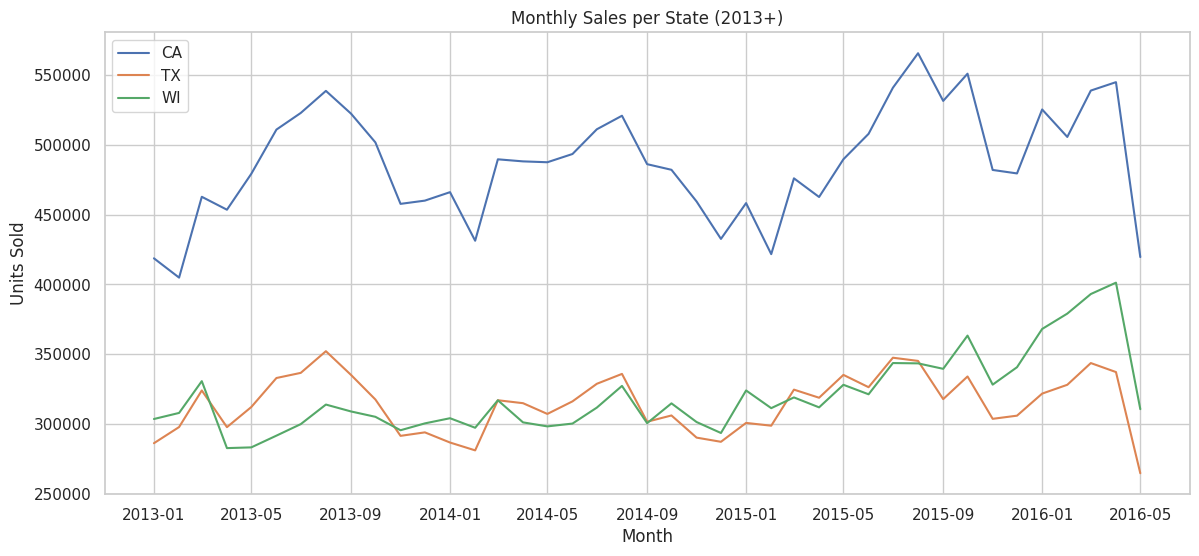

📅 Monthly Sales Summary per State:
 - CA: highest sales in August 2015 with 565672 units sold.
 - TX: highest sales in August 2013 with 352173 units sold.
 - WI: highest sales in April 2016 with 401284 units sold.


In [13]:
# ================================
# Monthly Sales Comparison per State
# ================================

# Merge day_cols with calendar dates
day_sales = sales[["state_id"] + day_cols].groupby("state_id").sum().T.reset_index()
day_sales = day_sales.rename(columns={"index":"d"})
day_sales = day_sales.merge(calendar[["d","date"]], on="d", how="left")

# Add year-month column
day_sales["year_month"] = day_sales["date"].dt.to_period("M")

# Aggregate by month & state
monthly_sales = (
    day_sales.groupby(["year_month"])
    [["CA","TX","WI"]]  # the state_id columns
    .sum()
    .reset_index()
)

# Convert back to datetime for plotting
monthly_sales["year_month"] = monthly_sales["year_month"].dt.to_timestamp()

# Plot
plt.figure(figsize=(14,6))
for state in ["CA","TX","WI"]:
    plt.plot(monthly_sales["year_month"], monthly_sales[state], label=state)

plt.legend()
plt.title("Monthly Sales per State (2013+)")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.show()

# -------------------------
# Text-based insight summary
# -------------------------
print("📅 Monthly Sales Summary per State:")
for state in ["CA","TX","WI"]:
    top_month = monthly_sales.sort_values(state, ascending=False).iloc[0]
    print(f" - {state}: highest sales in {top_month['year_month'].strftime('%B %Y')} "
          f"with {int(top_month[state])} units sold.")


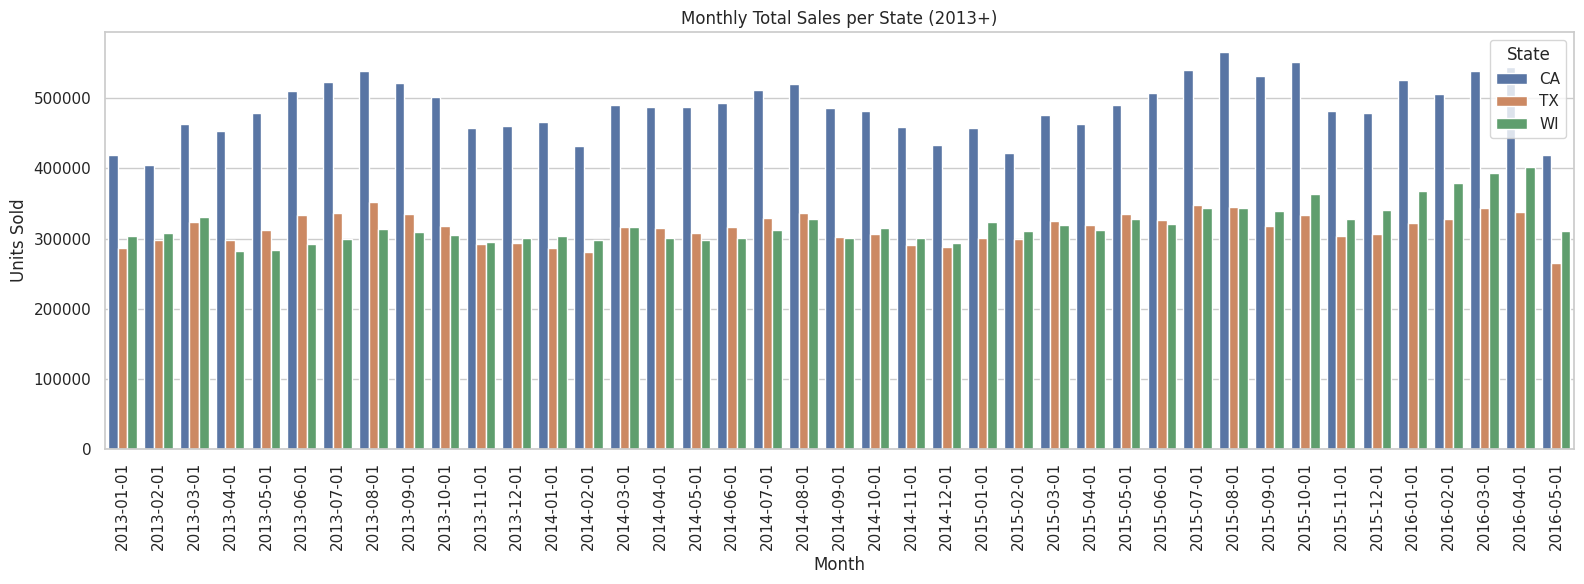

📊 Bar Chart Insight:
 - Compare states side by side each month.
 - Useful for spotting if one state consistently dominates sales, or if seasonality differs.


In [14]:
# ================================
# Monthly Sales Comparison per State (Bar Plot)
# ================================

import seaborn as sns

# Reuse monthly_sales from earlier step
# monthly_sales: columns -> [year_month, CA, TX, WI]

# Melt into long format for seaborn
monthly_sales_melted = monthly_sales.melt(
    id_vars="year_month",
    value_vars=["CA","TX","WI"],
    var_name="state",
    value_name="units_sold"
)

# Plot grouped bar chart
plt.figure(figsize=(16,6))
sns.barplot(
    data=monthly_sales_melted,
    x="year_month", y="units_sold", hue="state"
)
plt.xticks(rotation=90)
plt.title("Monthly Total Sales per State (2013+)")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.legend(title="State")
plt.tight_layout()
plt.show()

# -------------------------
# Text-based insights
# -------------------------
print("📊 Bar Chart Insight:")
print(" - Compare states side by side each month.")
print(" - Useful for spotting if one state consistently dominates sales, or if seasonality differs.")


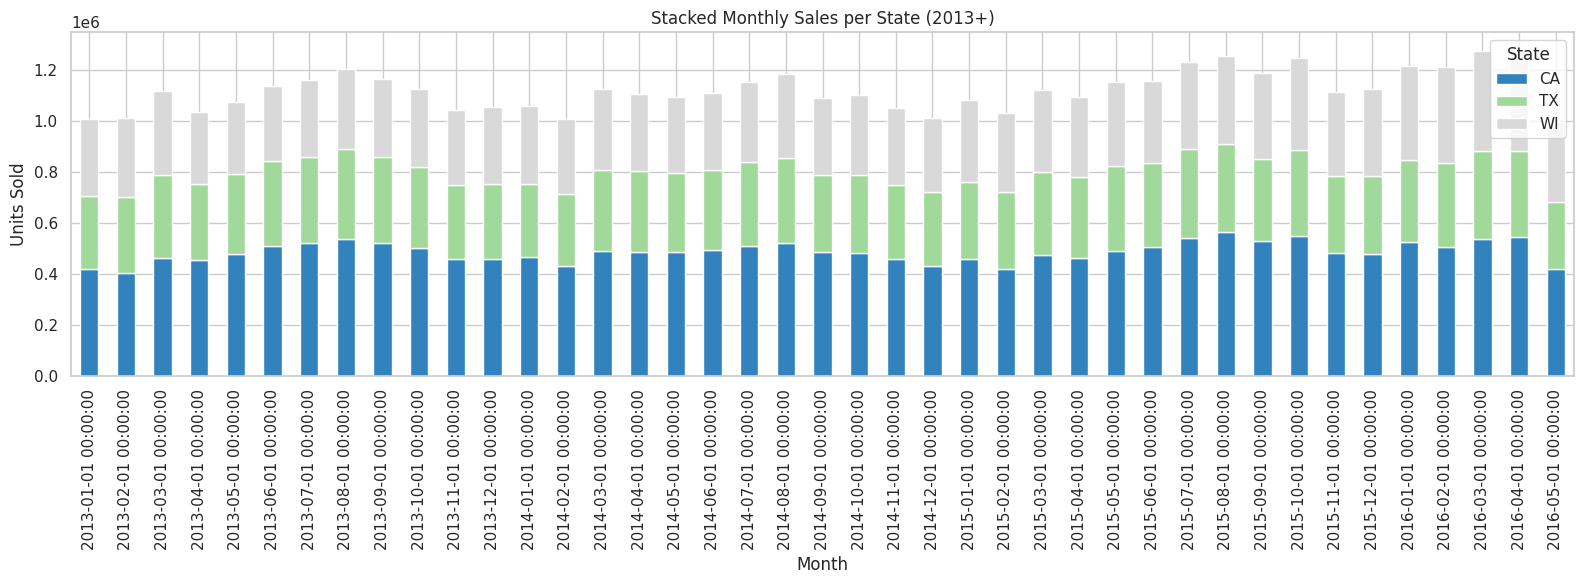

📊 Stacked Bar Insight:
 - Height of bar = total monthly sales across all states.
 - Each color segment = state’s contribution.
 - Useful for spotting seasonal peaks and proportion differences.


In [15]:
# ================================
# Stacked Bar Plot: Monthly Sales per State
# ================================

# Pivot to wide format (already in monthly_sales)
stacked_df = monthly_sales.set_index("year_month")[["CA","TX","WI"]]

# Plot stacked bar chart
stacked_df.plot(
    kind="bar",
    stacked=True,
    figsize=(16,6),
    colormap="tab20c"
)
plt.title("Stacked Monthly Sales per State (2013+)")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.xticks(rotation=90)
plt.legend(title="State")
plt.tight_layout()
plt.show()

# -------------------------
# Text-based insights
# -------------------------
print("📊 Stacked Bar Insight:")
print(" - Height of bar = total monthly sales across all states.")
print(" - Each color segment = state’s contribution.")
print(" - Useful for spotting seasonal peaks and proportion differences.")


In [16]:
# ================================
# Events in August
# ================================

# Filter for August (month == 8)
august_calendar = calendar[calendar["date"].dt.month == 8]

# List all unique events in August
aug_events = august_calendar["event_name_1"].dropna().unique()
print("📅 Unique Events in August:")
for ev in aug_events:
    print(" -", ev)


# Count how many times each event occurs in August
event_counts = august_calendar["event_name_1"].value_counts()
print("\n📊 Event Occurrences in August:")
print(event_counts)

# # Optional: visualize event distribution in August
# sns.countplot(
#     x="event_name_1",
#     data=august_calendar[august_calendar["event_name_1"].notnull()],
#     order=event_counts.index
# )
# plt.xticks(rotation=90)
# plt.title("Event Distribution in August")
# plt.ylabel("Number of Days")
# plt.xlabel("Event Name")
# plt.tight_layout()
# plt.show()


📅 Unique Events in August:
 - Eid al-Fitr

📊 Event Occurrences in August:
event_name_1
Eid al-Fitr    1
Name: count, dtype: int64


📊 Average Sales per State: Event vs Non-Event Days (August Sample)
          Non-Event Days  Event Days
state_id                            
CA              1.607337    1.472222
TX              0.839275    0.600000
WI              0.632075    0.603774


/tmp/ipython-input-497078373.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  august_sample["is_event"] = np.where(august_sample["event_name_1"].notnull(), 1, 0)


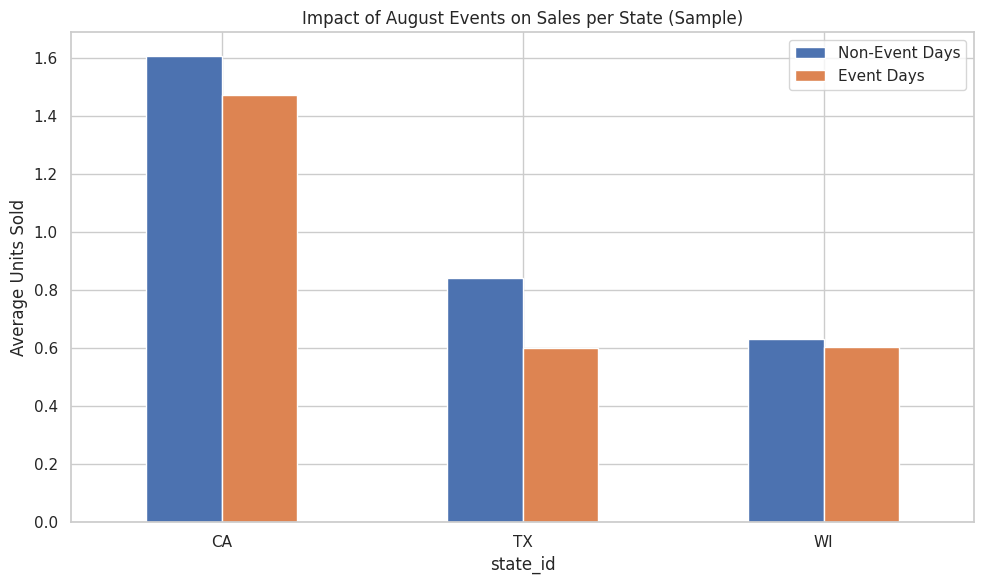

In [17]:
# ================================
# August Events vs Sales per State
# ================================

# Filter sales_long sample to August (or create small sample if memory is tight)
# We'll use previously created sample_sales for events analysis
august_sample = sample_sales[sample_sales["date"].dt.month == 8]

# Add a column: is_event (1 if event_name_1 exists, else 0)
august_sample["is_event"] = np.where(august_sample["event_name_1"].notnull(), 1, 0)

# Aggregate average sales per state on event vs non-event days
state_event_sales = august_sample.groupby(["state_id", "is_event"])["sales"].mean().reset_index()

# Pivot for easier plotting
state_event_pivot = state_event_sales.pivot(index="state_id", columns="is_event", values="sales")
state_event_pivot.columns = ["Non-Event Days", "Event Days"]
print("📊 Average Sales per State: Event vs Non-Event Days (August Sample)")
print(state_event_pivot)

# Optional: visualize comparison
state_event_pivot.plot(kind="bar", figsize=(10,6))
plt.title("Impact of August Events on Sales per State (Sample)")
plt.ylabel("Average Units Sold")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


📊 Average Sales per State: SNAP vs Non-SNAP Days (August Sample)
snap_flag  Non-SNAP Day  SNAP Day
state_id                         
CA             1.593474  1.631944
TX             0.793862  0.926667
WI             0.583109  0.733962


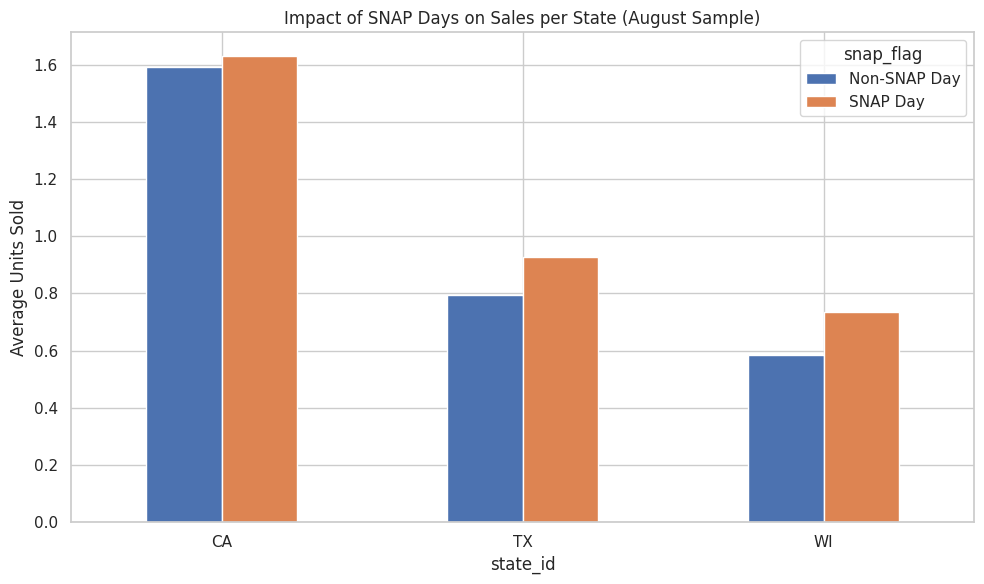

In [18]:
# ================================
# SNAP Impact on Sales in August
# ================================

# 1. Filter calendar for August
august_calendar = calendar[calendar["date"].dt.month == 8]

# 2. Merge with sample_sales (already has 'date', 'state_id', 'sales')
august_sales = sample_sales.merge(
    august_calendar[["date","snap_CA","snap_TX","snap_WI"]],
    on="date",
    how="left"
)

# 3. Create a SNAP flag per row based on state
def snap_flag(row):
    if row["state_id"] == "CA":
        return row["snap_CA"]
    elif row["state_id"] == "TX":
        return row["snap_TX"]
    elif row["state_id"] == "WI":
        return row["snap_WI"]
    else:
        return 0

august_sales["snap_flag"] = august_sales.apply(snap_flag, axis=1)

# 4. Aggregate: average sales on SNAP vs non-SNAP days per state
snap_sales = august_sales.groupby(["state_id","snap_flag"])["sales"].mean().reset_index()
snap_sales["snap_flag"] = snap_sales["snap_flag"].map({0:"Non-SNAP Day",1:"SNAP Day"})

# Pivot for plotting
snap_sales_pivot = snap_sales.pivot(index="state_id", columns="snap_flag", values="sales")

# 5. Display results
print("📊 Average Sales per State: SNAP vs Non-SNAP Days (August Sample)")
print(snap_sales_pivot)

# 6. Bar plot
snap_sales_pivot.plot(kind="bar", figsize=(10,6))
plt.title("Impact of SNAP Days on Sales per State (August Sample)")
plt.ylabel("Average Units Sold")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [19]:
# ================================
# SNAP Allowed Dates per State
# ================================

# Filter calendar for SNAP days
snap_dates = calendar[["date","snap_CA","snap_TX","snap_WI"]]

# Function to print dates per state
def print_snap_dates(state_col, state_name):
    dates = snap_dates[snap_dates[state_col]==1]["date"]
    print(f"\n📅 SNAP Allowed Dates in {state_name}:")
    for d in dates.dt.strftime('%Y-%m-%d'):
        print(" -", d)

# Print for each state
print_snap_dates("snap_CA", "California")
print_snap_dates("snap_TX", "Texas")
print_snap_dates("snap_WI", "Wisconsin")



📅 SNAP Allowed Dates in California:
 - 2013-01-01
 - 2013-01-02
 - 2013-01-03
 - 2013-01-04
 - 2013-01-05
 - 2013-01-06
 - 2013-01-07
 - 2013-01-08
 - 2013-01-09
 - 2013-01-10
 - 2013-02-01
 - 2013-02-02
 - 2013-02-03
 - 2013-02-04
 - 2013-02-05
 - 2013-02-06
 - 2013-02-07
 - 2013-02-08
 - 2013-02-09
 - 2013-02-10
 - 2013-03-01
 - 2013-03-02
 - 2013-03-03
 - 2013-03-04
 - 2013-03-05
 - 2013-03-06
 - 2013-03-07
 - 2013-03-08
 - 2013-03-09
 - 2013-03-10
 - 2013-04-01
 - 2013-04-02
 - 2013-04-03
 - 2013-04-04
 - 2013-04-05
 - 2013-04-06
 - 2013-04-07
 - 2013-04-08
 - 2013-04-09
 - 2013-04-10
 - 2013-05-01
 - 2013-05-02
 - 2013-05-03
 - 2013-05-04
 - 2013-05-05
 - 2013-05-06
 - 2013-05-07
 - 2013-05-08
 - 2013-05-09
 - 2013-05-10
 - 2013-06-01
 - 2013-06-02
 - 2013-06-03
 - 2013-06-04
 - 2013-06-05
 - 2013-06-06
 - 2013-06-07
 - 2013-06-08
 - 2013-06-09
 - 2013-06-10
 - 2013-07-01
 - 2013-07-02
 - 2013-07-03
 - 2013-07-04
 - 2013-07-05
 - 2013-07-06
 - 2013-07-07
 - 2013-07-08
 - 2013-07-

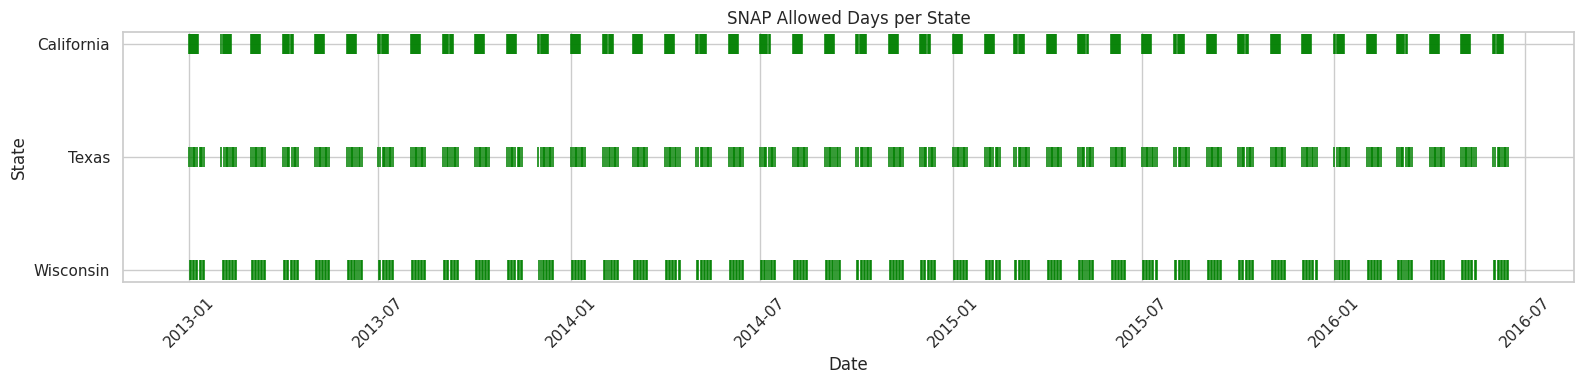

In [20]:
# ================================
# Plot SNAP Days per State
# ================================

import matplotlib.dates as mdates

# Prepare data in long format for plotting
snap_long = snap_dates.melt(
    id_vars="date",
    value_vars=["snap_CA","snap_TX","snap_WI"],
    var_name="state",
    value_name="snap_flag"
)

# Map state column to readable names
snap_long["state"] = snap_long["state"].map({
    "snap_CA":"California",
    "snap_TX":"Texas",
    "snap_WI":"Wisconsin"
})

# Keep only SNAP days
snap_long = snap_long[snap_long["snap_flag"]==1]

# Plot
plt.figure(figsize=(16,4))
sns.scatterplot(data=snap_long, x="date", y="state", marker="|", s=200, color="green")

plt.title("SNAP Allowed Days per State")
plt.xlabel("Date")
plt.ylabel("State")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-4242165147.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snap_dates["year_month"] = snap_dates["date"].dt.to_period("M")


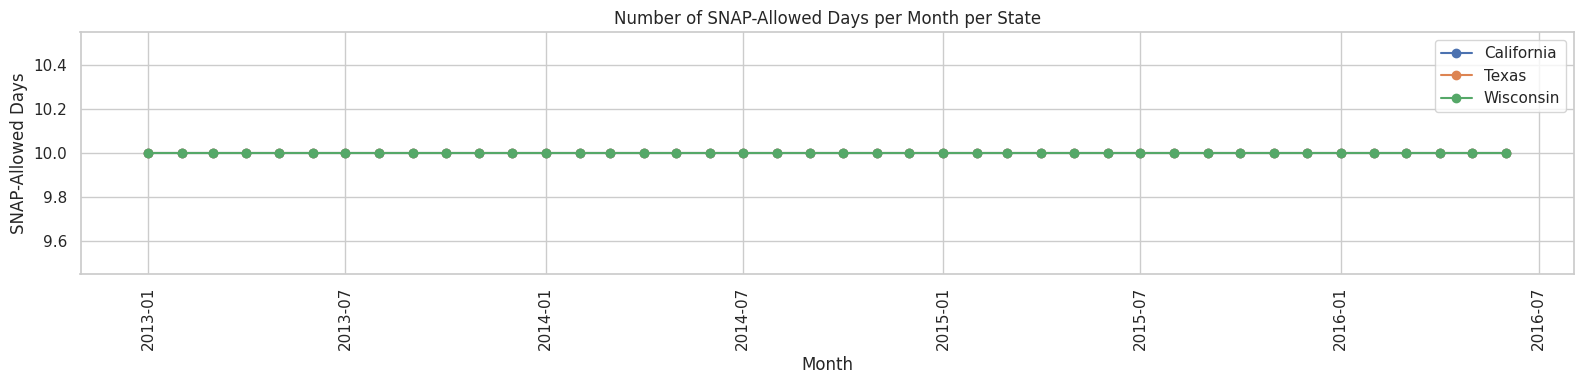

📊 SNAP Days in August per State:
   year_month  California  Texas  Wisconsin
7  2013-08-01          10     10         10
19 2014-08-01          10     10         10
31 2015-08-01          10     10         10


In [21]:
# ================================
# Compare SNAP Days per Month
# ================================

# Add year-month column
snap_dates["year_month"] = snap_dates["date"].dt.to_period("M")

# Aggregate: sum of SNAP days per month per state
snap_monthly = snap_dates.groupby("year_month")[["snap_CA","snap_TX","snap_WI"]].sum().reset_index()

# Convert year_month to datetime for plotting
snap_monthly["year_month"] = snap_monthly["year_month"].dt.to_timestamp()

# Rename columns for readability
snap_monthly = snap_monthly.rename(columns={
    "snap_CA":"California",
    "snap_TX":"Texas",
    "snap_WI":"Wisconsin"
})

# Plot line chart
plt.figure(figsize=(16,4))
for state in ["California","Texas","Wisconsin"]:
    plt.plot(snap_monthly["year_month"], snap_monthly[state], marker="o", label=state)

plt.title("Number of SNAP-Allowed Days per Month per State")
plt.xlabel("Month")
plt.ylabel("SNAP-Allowed Days")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: highlight August
august_snap = snap_monthly[snap_monthly["year_month"].dt.month == 8]
print("📊 SNAP Days in August per State:")
print(august_snap[["year_month","California","Texas","Wisconsin"]])


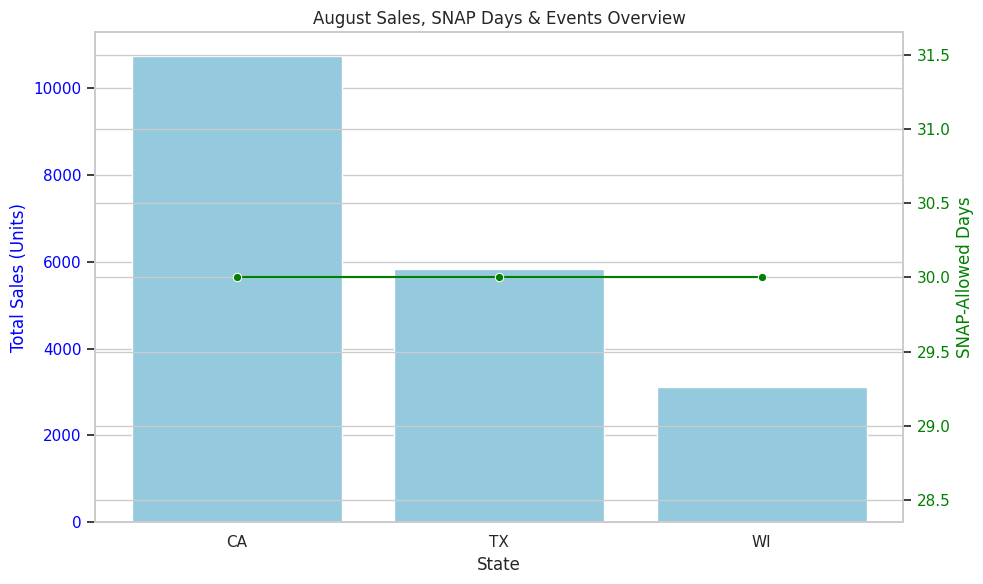

📊 August Sales Insights:
 - CA: 10753 units sold, 30 SNAP-allowed days.
 - TX: 5836 units sold, 30 SNAP-allowed days.
 - WI: 3114 units sold, 30 SNAP-allowed days.

📅 Number of unique events in August: 1
Events include: Eid al-Fitr

🏷 Top 3 categories contributing to August sales (sample-based):
 - FOODS: 13439 units sold
 - HOUSEHOLD: 3560 units sold
 - HOBBIES: 2704 units sold

✅ August Sales Insights Completed.


In [22]:
# ================================
# Why Sales Spike in August? Combined Analysis
# ================================

# 1️⃣ Filter August sales (sample for memory efficiency)
august_sales_sample = sample_sales[sample_sales["date"].dt.month == 8]

# Aggregate total units sold per state
aug_state_sales = august_sales_sample.groupby("state_id")["sales"].sum().reset_index()
aug_state_sales.columns = ["State","Total Sales"]

# 2️⃣ Count SNAP-allowed days in August
aug_snap = calendar[calendar["date"].dt.month==8]
snap_counts = {
    "CA": aug_snap["snap_CA"].sum(), # Changed key to 'CA'
    "TX": aug_snap["snap_TX"].sum(), # Changed key to 'TX'
    "WI": aug_snap["snap_WI"].sum()  # Changed key to 'WI'
}
snap_df = pd.DataFrame(list(snap_counts.items()), columns=["State","SNAP Days"])

# 3️⃣ Count unique events in August
aug_events = august_calendar["event_name_1"].dropna().unique()
num_events = len(aug_events)

# 4️⃣ Top contributing categories in August (sample-based)
cat_sales_aug = august_sales_sample.groupby("cat_id")["sales"].sum().sort_values(ascending=False)
top_categories = cat_sales_aug.head(3)

# -------------------------
# Plot August Sales + SNAP Days per State
# -------------------------
fig, ax1 = plt.subplots(figsize=(10,6))

# Bar plot for total sales
sns.barplot(x="State", y="Total Sales", data=aug_state_sales, ax=ax1, color="skyblue")
ax1.set_ylabel("Total Sales (Units)", color="blue")
ax1.set_title("August Sales, SNAP Days & Events Overview")
ax1.tick_params(axis='y', labelcolor="blue")

# Line plot for SNAP Days (secondary axis)
ax2 = ax1.twinx()
sns.lineplot(x="State", y="SNAP Days", data=snap_df, ax=ax2, marker="o", color="green")
ax2.set_ylabel("SNAP-Allowed Days", color="green")
ax2.tick_params(axis='y', labelcolor="green")

plt.tight_layout()
plt.show()

# -------------------------
# Text-based Summary
# -------------------------
print("📊 August Sales Insights:")
for idx, row in aug_state_sales.iterrows():
    state = row["State"]
    print(f" - {state}: {row['Total Sales']} units sold, {snap_counts[state]} SNAP-allowed days.")

print(f"\n📅 Number of unique events in August: {num_events}")
print("Events include:", ", ".join(aug_events))

print("\n🏷 Top 3 categories contributing to August sales (sample-based):")
for cat, val in top_categories.items():
    print(f" - {cat}: {int(val)} units sold")

print("\n✅ August Sales Insights Completed.")

In [23]:
# ================================
# Store-wise EDA: Trends, Comparisons & Insights
# ================================
# Assumptions:
# - `sales` DataFrame is loaded (sales_train_evaluation.csv) with day columns filtered to 2013+ in `day_cols`
# - `calendar` DataFrame is loaded and filtered (2013+)
# - `day_cols` is a list of day column names (e.g. ['d_1','d_2',...]) corresponding to calendar rows
# - `sample_sales` may exist for item-level sampling but this analysis aggregates across all items per store

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,5)

# ---------- Helper: ensure types are efficient ----------
for c in day_cols:
    sales[c] = sales[c].astype('int32')  # int16 might overflow when summing many items, so use int32 for safe sum

# ---------- 1) Build daily store-level totals (wide) ----------
# sales has rows = item-store combos and columns = day_cols. store_id column exists.
store_daily = sales.groupby("store_id")[day_cols].sum().T   # index = d_x, columns = store IDs (e.g. CA_1,...)
store_daily.index.name = "d"
store_daily = store_daily.reset_index()

# Merge with calendar to get absolute date, year, month, week, weekday
store_daily = store_daily.merge(calendar[["d","date","wm_yr_wk"]], on="d", how="left")
store_daily["year"] = store_daily["date"].dt.year
store_daily["month"] = store_daily["date"].dt.month
store_daily["year_month"] = store_daily["date"].dt.to_period("M").dt.to_timestamp()
store_daily["week"] = store_daily["date"].dt.isocalendar().week
store_daily["weekday"] = store_daily["date"].dt.day_name()

# reorder columns: date then stores...
store_cols = [c for c in store_daily.columns if c.startswith(("CA_","TX_","WI_"))]  # typical store IDs
cols_order = ["d","date","year","month","year_month","week","weekday"] + store_cols
store_daily = store_daily[cols_order]

print("Store daily shape:", store_daily.shape)
store_daily.head()


Store daily shape: (1238, 17)


,d,date,year,month,year_month,week,weekday,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
0,d_704,2013-01-01,2013,1,2013-01-01,1,Tuesday,2552,2124,3580,1384,2362,3402,2570,1918,2187,2008
1,d_705,2013-01-02,2013,1,2013-01-01,1,Wednesday,3532,2464,5510,1746,2337,3367,2683,2650,4224,3671
2,d_706,2013-01-03,2013,1,2013-01-01,1,Thursday,3957,2468,5999,1778,2796,4064,3209,2630,5086,4254
3,d_707,2013-01-04,2013,1,2013-01-01,1,Friday,4134,2605,5828,1959,2572,3529,2760,2836,3984,3535
4,d_708,2013-01-05,2013,1,2013-01-01,1,Saturday,4673,3507,6842,2079,3478,4583,3249,4207,5581,5088


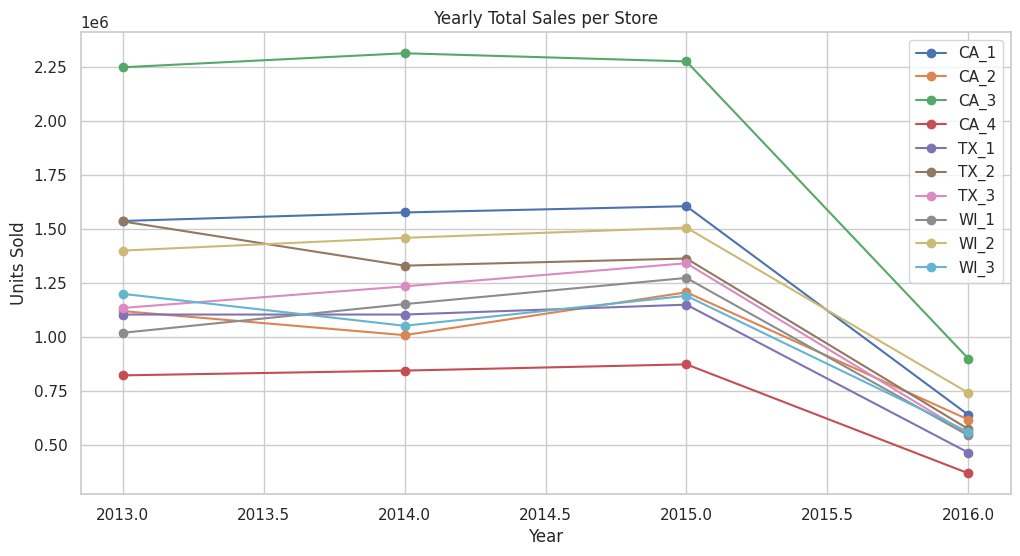

Year-over-year % change (sample):


,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
year,,,,,,,,,,
2014,0.025603,-0.099256,0.028859,0.026793,-0.000005,-0.133130,0.087741,0.129983,0.042041,-0.123077
2015,0.018335,0.196204,-0.016333,0.034183,0.041325,0.024793,0.086580,0.104960,0.032332,0.131702
2016,-0.600657,-0.487213,-0.603793,-0.575824,-0.594553,-0.578026,-0.588318,-0.571535,-0.506858,-0.528145


In [24]:
# Yearly total sales per store
yearly_store = store_daily.groupby("year")[store_cols].sum().reset_index()

# Plot: one line per store across years
plt.figure(figsize=(12,6))
for s in store_cols:
    plt.plot(yearly_store["year"], yearly_store[s], marker="o", label=s)
plt.title("Yearly Total Sales per Store")
plt.xlabel("Year")
plt.ylabel("Units Sold")
plt.legend()
plt.show()

# Text summary of yearly growth/decline
yearly_change = yearly_store.set_index("year").pct_change().dropna()
print("Year-over-year % change (sample):")
display(yearly_change.tail())   # show last few rows


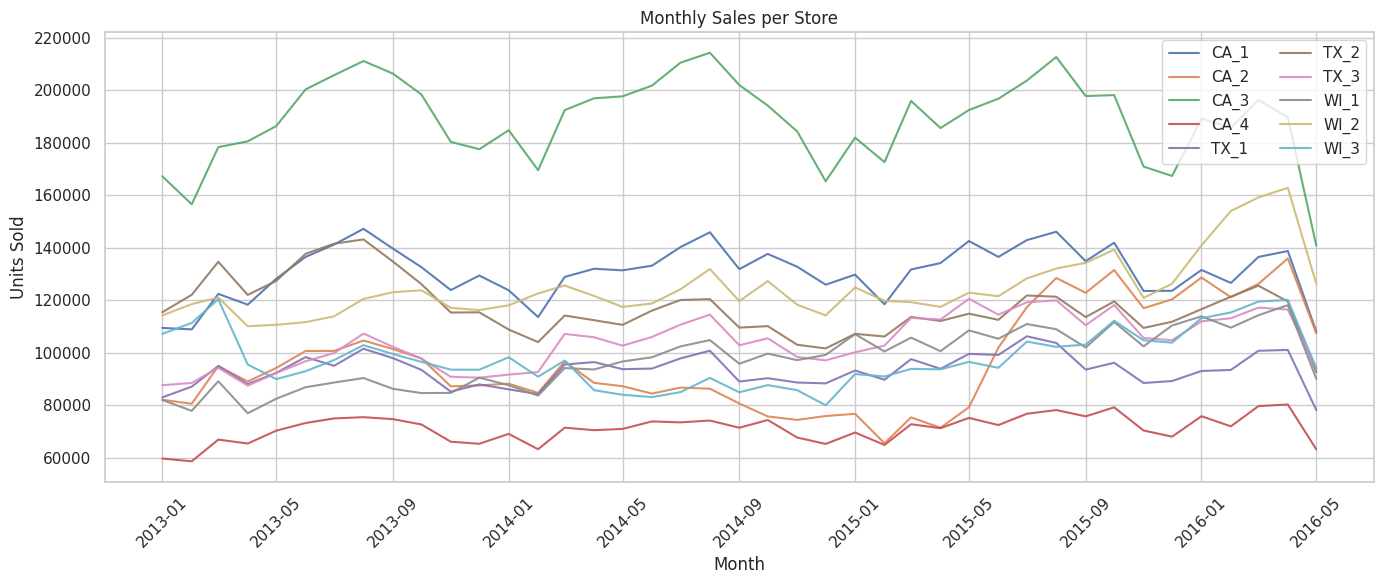

In [30]:
# Monthly totals per store (year_month)
monthly_store = store_daily.groupby("year_month")[store_cols].sum().reset_index()

# Grouped line-plot: monthly trends for each store (can be many months - zoom as needed)
plt.figure(figsize=(14,6))
for s in store_cols:
    plt.plot(monthly_store["year_month"], monthly_store[s], label=s, alpha=0.9)
plt.title("Monthly Sales per Store")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.legend(ncol=2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



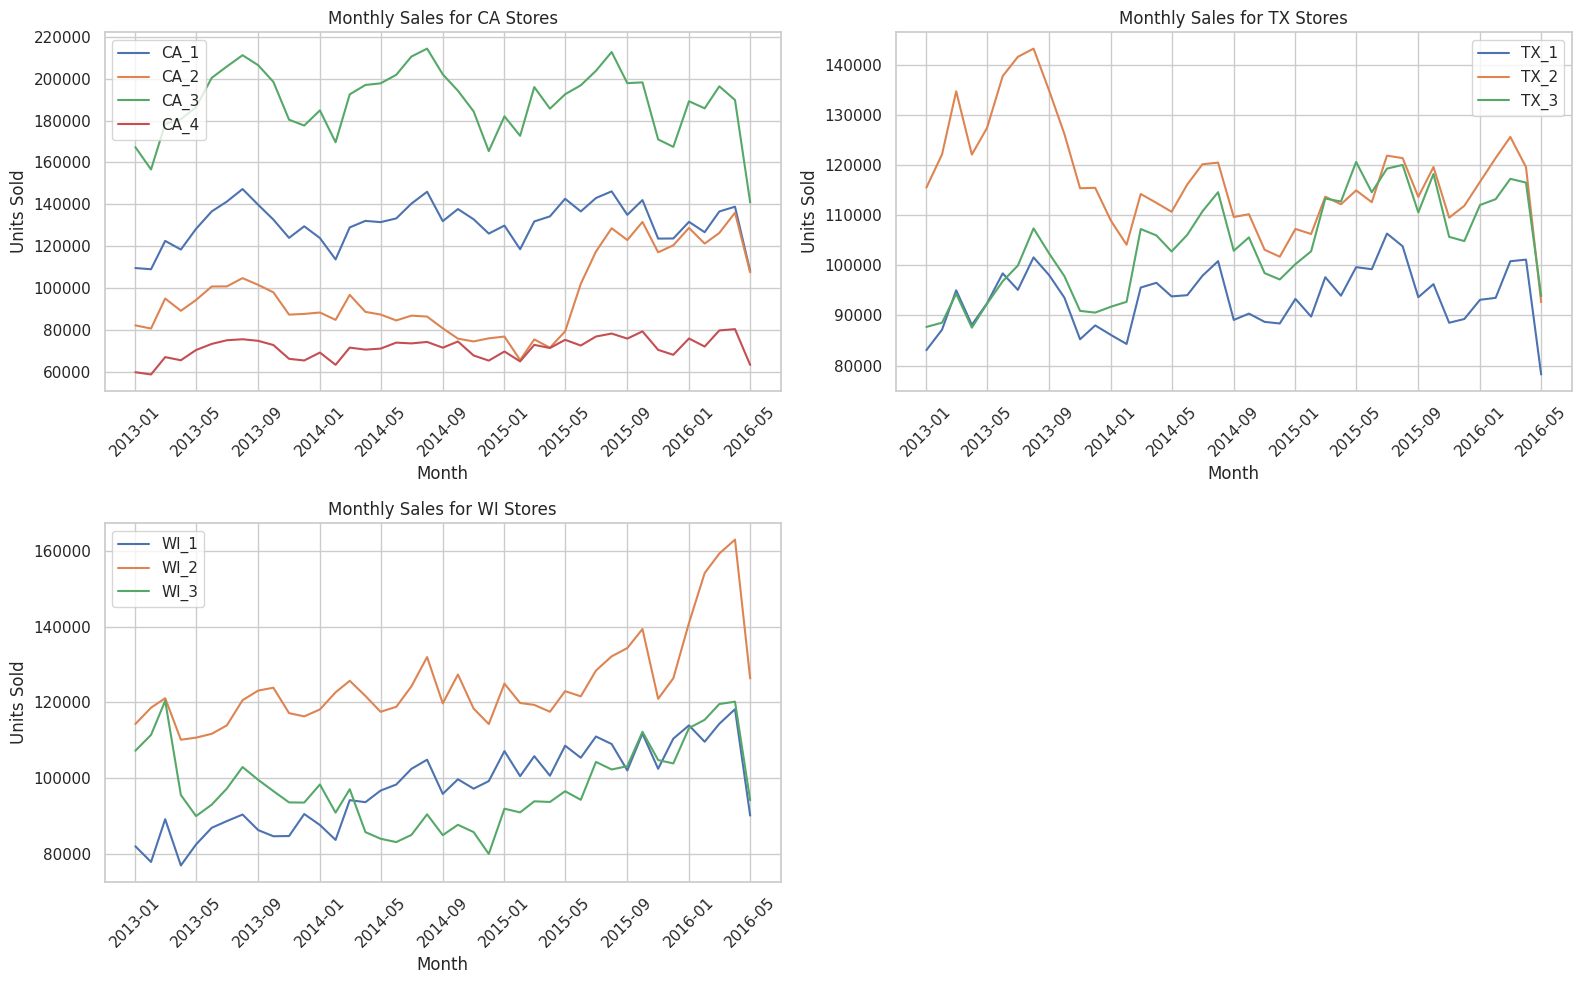

In [31]:
# Optional: create small multiples per state to avoid clutter (each store plotted in its state group)
stores_by_state = {}
for s in store_cols:
    state = s.split("_")[0]   # e.g. "CA"
    stores_by_state.setdefault(state, []).append(s)

# Create a 2x2 grid of subplots to show monthly sales per state
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten() # Flatten the 2D array of axes for easier iteration

# Define the order of states for the subplots to ensure consistent placement
state_order = ["CA", "TX", "WI"]

for i, state in enumerate(state_order):
    if state in stores_by_state:
        ax = axes[i]
        for s in stores_by_state[state]:
            ax.plot(monthly_store["year_month"], monthly_store[s], label=s)
        ax.set_title(f"Monthly Sales for {state} Stores")
        ax.set_xlabel("Month")
        ax.set_ylabel("Units Sold")
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
    else:
        # Hide any unused subplots if there are fewer states than grid spots
        fig.delaxes(axes[i])

# Hide any remaining unused subplots if state_order had fewer elements than the grid
for j in range(len(state_order), len(axes)):
     fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

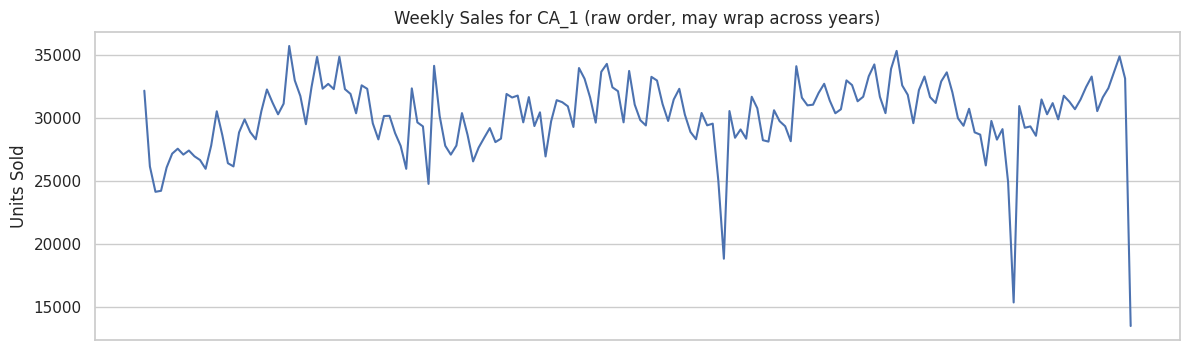

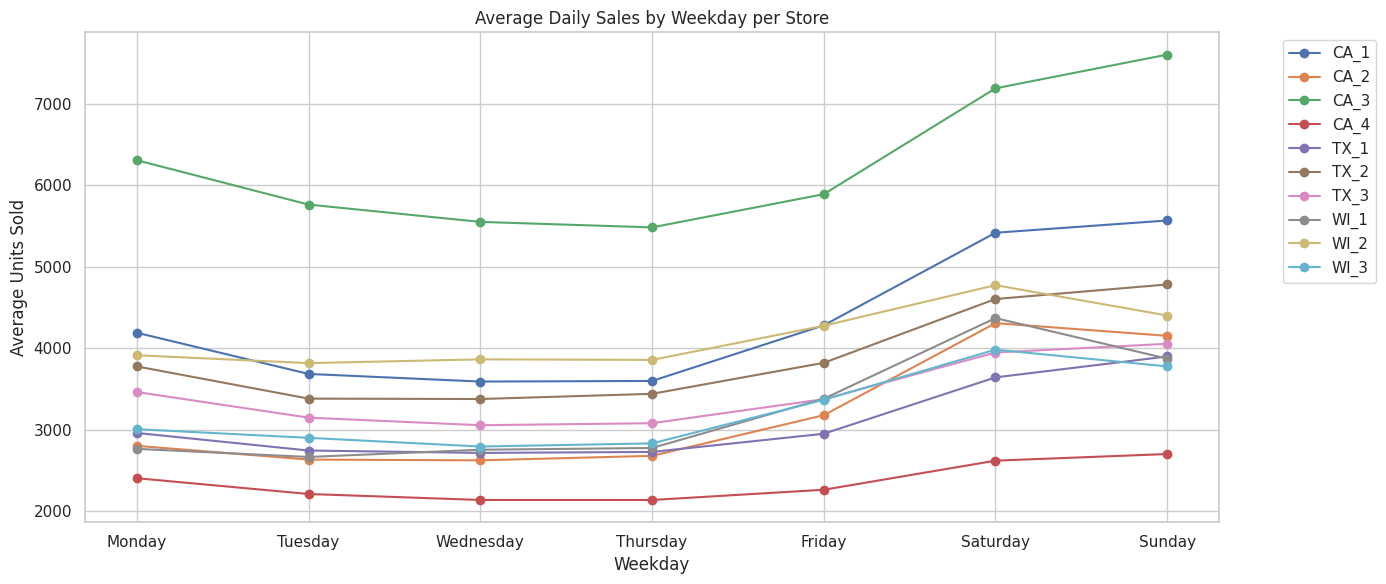

In [33]:
# Weekly aggregation per store (sum over ISO weeks, year-week)
weekly_store = store_daily.groupby(["year","week"])[store_cols].sum().reset_index()

# Plot weekly time series for a chosen store (example: CA_1)
example_store = store_cols[0]
plt.figure(figsize=(14,4))
plt.plot(weekly_store["week"].astype(str) + "-" + weekly_store["year"].astype(str), weekly_store[example_store])
plt.title(f"Weekly Sales for {example_store} (raw order, may wrap across years)")
plt.xticks([],[])  # hide crowded ticks
plt.ylabel("Units Sold")
plt.show()

# Weekday boxplot per store (distribution of daily sales by weekday)
plt.figure(figsize=(14,6))
df_for_box = store_daily.melt(id_vars=["date","weekday"], value_vars=store_cols, var_name="store", value_name="sales")
# sample if needed:
# df_box_sample = df_for_box.groupby("store").sample(n=200, random_state=42) if df_for_box.shape[0] > 200000 else df_for_box

# Aggregate daily sales by weekday and store for line plot
weekday_sales_agg = df_for_box.groupby(["weekday","store"])["sales"].mean().reset_index()

# Define the order of weekdays for plotting
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
weekday_sales_agg["weekday"] = pd.Categorical(weekday_sales_agg["weekday"], categories=weekday_order, ordered=True)
weekday_sales_agg = weekday_sales_agg.sort_values("weekday")


# Plot line chart
for store in store_cols:
    store_data = weekday_sales_agg[weekday_sales_agg["store"] == store]
    plt.plot(store_data["weekday"], store_data["sales"], marker='o', label=store)


plt.title("Average Daily Sales by Weekday per Store")
plt.xlabel("Weekday")
plt.ylabel("Average Units Sold")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

In [41]:
# Optional: get top-N items (bottom level) per store — this needs grouping on sales rows (not aggregated wide)
# This operation does not melt all days if we sum across day_cols per row first.

# Filter sales data for the year 2015
# Need to identify which day columns correspond to 2015
days_2015 = calendar[calendar["date"].dt.year == 2015]["d"].tolist()

# Calculate per-row total across 2015 days more efficiently
# Select only the 2015 day columns and sum across rows
sales_2015_totals = sales[days_2015].sum(axis=1)

top_items_per_store_2015 = {}
for s in store_cols:
    # Filter the original sales dataframe by store_id and then use the calculated 2015 totals
    sub = sales[sales["store_id"]==s].copy() # Create a copy to avoid SettingWithCopyWarning if modifying further
    sub["total_2015"] = sales_2015_totals[sub.index] # Align totals using index

    sub = sub.sort_values("total_2015", ascending=False).head(10)
    top_items_per_store_2015[s] = sub[["id","item_id","dept_id","cat_id","total_2015"]]

# display top items for first few stores
for s in list(top_items_per_store_2015.keys())[:4]:
    print(f"\nTop items for {s} in 2015")
    display(top_items_per_store_2015[s])


Top items for CA_1 in 2015


,id,item_id,dept_id,cat_id,total_2015
2314,FOODS_3_090_CA_1_evaluation,FOODS_3_090,FOODS_3,FOODS,18482
2810,FOODS_3_586_CA_1_evaluation,FOODS_3_586,FOODS_3,FOODS,16361
2344,FOODS_3_120_CA_1_evaluation,FOODS_3_120,FOODS_3,FOODS,15408
2476,FOODS_3_252_CA_1_evaluation,FOODS_3_252,FOODS_3,FOODS,14751
2506,FOODS_3_282_CA_1_evaluation,FOODS_3_282,FOODS_3,FOODS,10679
2288,FOODS_3_064_CA_1_evaluation,FOODS_3_064,FOODS_3,FOODS,10115
2811,FOODS_3_587_CA_1_evaluation,FOODS_3_587,FOODS_3,FOODS,9911
2937,FOODS_3_714_CA_1_evaluation,FOODS_3_714,FOODS_3,FOODS,9184
2905,FOODS_3_681_CA_1_evaluation,FOODS_3_681,FOODS_3,FOODS,8374
2962,FOODS_3_741_CA_1_evaluation,FOODS_3_741,FOODS_3,FOODS,6986



Top items for CA_2 in 2015


,id,item_id,dept_id,cat_id,total_2015
5525,FOODS_3_252_CA_2_evaluation,FOODS_3_252,FOODS_3,FOODS,12568
5859,FOODS_3_586_CA_2_evaluation,FOODS_3_586,FOODS_3,FOODS,12132
5363,FOODS_3_090_CA_2_evaluation,FOODS_3_090,FOODS_3,FOODS,11752
5561,FOODS_3_288_CA_2_evaluation,FOODS_3_288,FOODS_3,FOODS,7850
5828,FOODS_3_555_CA_2_evaluation,FOODS_3_555,FOODS_3,FOODS,6686
5393,FOODS_3_120_CA_2_evaluation,FOODS_3_120,FOODS_3,FOODS,6562
6010,FOODS_3_739_CA_2_evaluation,FOODS_3_739,FOODS_3,FOODS,6225
6074,FOODS_3_804_CA_2_evaluation,FOODS_3_804,FOODS_3,FOODS,5576
5353,FOODS_3_080_CA_2_evaluation,FOODS_3_080,FOODS_3,FOODS,5435
5592,FOODS_3_319_CA_2_evaluation,FOODS_3_319,FOODS_3,FOODS,5428



Top items for CA_3 in 2015


,id,item_id,dept_id,cat_id,total_2015
8412,FOODS_3_090_CA_3_evaluation,FOODS_3_090,FOODS_3,FOODS,33279
8442,FOODS_3_120_CA_3_evaluation,FOODS_3_120,FOODS_3,FOODS,31598
8908,FOODS_3_586_CA_3_evaluation,FOODS_3_586,FOODS_3,FOODS,26792
8574,FOODS_3_252_CA_3_evaluation,FOODS_3_252,FOODS_3,FOODS,16695
6324,HOBBIES_1_234_CA_3_evaluation,HOBBIES_1_234,HOBBIES_1,HOBBIES,13242
8909,FOODS_3_587_CA_3_evaluation,FOODS_3_587,FOODS_3,FOODS,12887
9003,FOODS_3_681_CA_3_evaluation,FOODS_3_681,FOODS_3,FOODS,12862
8610,FOODS_3_288_CA_3_evaluation,FOODS_3_288,FOODS_3,FOODS,11665
8604,FOODS_3_282_CA_3_evaluation,FOODS_3_282,FOODS_3,FOODS,11650
9035,FOODS_3_714_CA_3_evaluation,FOODS_3_714,FOODS_3,FOODS,10928



Top items for CA_4 in 2015


,id,item_id,dept_id,cat_id,total_2015
11461,FOODS_3_090_CA_4_evaluation,FOODS_3_090,FOODS_3,FOODS,9048
11958,FOODS_3_587_CA_4_evaluation,FOODS_3_587,FOODS_3,FOODS,5291
12084,FOODS_3_714_CA_4_evaluation,FOODS_3_714,FOODS_3,FOODS,4925
11957,FOODS_3_586_CA_4_evaluation,FOODS_3_586,FOODS_3,FOODS,4607
11653,FOODS_3_282_CA_4_evaluation,FOODS_3_282,FOODS_3,FOODS,3925
11623,FOODS_3_252_CA_4_evaluation,FOODS_3_252,FOODS_3,FOODS,3487
11573,FOODS_3_202_CA_4_evaluation,FOODS_3_202,FOODS_3,FOODS,3480
9194,HOBBIES_1_048_CA_4_evaluation,HOBBIES_1_048,HOBBIES_1,HOBBIES,3375
10856,FOODS_1_099_CA_4_evaluation,FOODS_1_099,FOODS_1,FOODS,3304
11470,FOODS_3_099_CA_4_evaluation,FOODS_3_099,FOODS_3,FOODS,3213


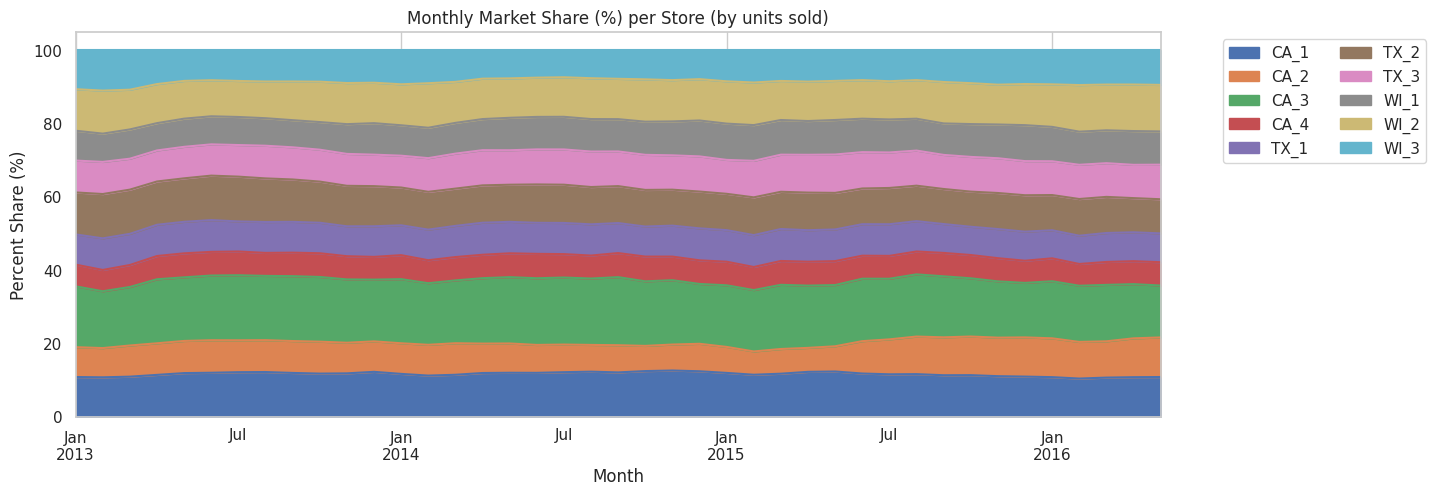

In [35]:
# Monthly store share: for each month, compute each store's (% of total)
monthly_totals = monthly_store.copy()
monthly_totals["total_all_stores"] = monthly_totals[store_cols].sum(axis=1)

share_df = monthly_totals[["year_month"] + store_cols].set_index("year_month")
share_pct = share_df.divide(share_df.sum(axis=1), axis=0) * 100  # percent share per month

# Plot stacked area of percent share to see relative performance
share_pct.plot(kind="area", stacked=True, figsize=(14,5))
plt.title("Monthly Market Share (%) per Store (by units sold)")
plt.ylabel("Percent Share (%)")
plt.xlabel("Month")
plt.legend(ncol=2, bbox_to_anchor=(1.05,1))
plt.show()


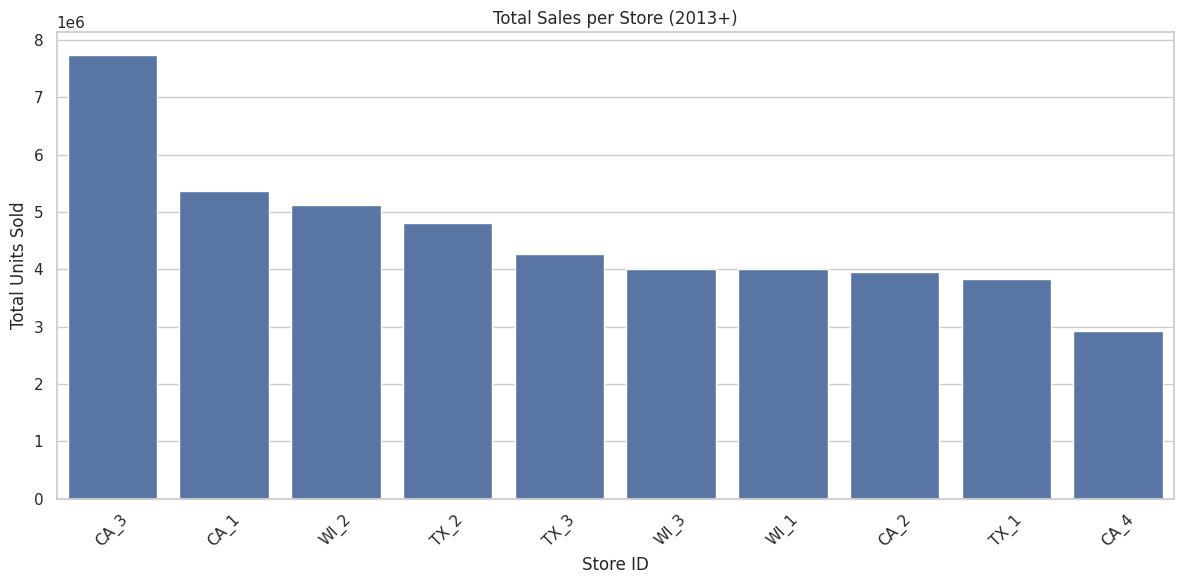

In [38]:
# Plot total sales per store
plt.figure(figsize=(12, 6))
sns.barplot(x="store", y="total_sales", data=metrics_df.sort_values("total_sales", ascending=False))
plt.title("Total Sales per Store (2013+)")
plt.xlabel("Store ID")
plt.ylabel("Total Units Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
# Print Automated Store Insights again for context
print("=== Automated Store Insights ===")
for line in insights:
    print(" -", line)

=== Automated Store Insights ===
 - Top store by total units sold: CA_3 with 7,743,007 units.
 - Most volatile store (CV): CA_2 (cv=0.31)
 - Store with most zero-sales days: CA_1 (0.2% zero-days).
 - Store with biggest monthly spike vs average: CA_2 (peak-to-avg ratio=1.41)


=== Automated Store Insights ===
 - Top store by total units sold: CA_3 with 7,743,007 units.
 - Most volatile store (CV): CA_2 (cv=0.31)
 - Store with most zero-sales days: CA_1 (0.2% zero-days).
 - Store with biggest monthly spike vs average: CA_2 (peak-to-avg ratio=1.41)

In [42]:
# Compare top items across stores
# Count how many stores each item appears in the top 10 list
item_counts = {}
for store, top_items_df in top_items_per_store_2015.items():
    for item_id in top_items_df["item_id"]:
        item_counts[item_id] = item_counts.get(item_id, 0) + 1

# Sort items by how many stores they appear in the top 10
sorted_item_counts = sorted(item_counts.items(), key=lambda item: item[1], reverse=True)

print("Items appearing in the top 10 of the most stores (in 2015):")
for item, count in sorted_item_counts:
    print(f"- {item}: in top 10 of {count} stores")

# Optional: Identify items that are unique to the top 10 of a single store
unique_top_items = {item: count for item, count in item_counts.items() if count == 1}
print("\nItems unique to the top 10 of only one store (in 2015):")
for item in unique_top_items:
    # Find which store this item belongs to in the top 10
    for store, top_items_df in top_items_per_store_2015.items():
        if item in top_items_df["item_id"].values:
            print(f"- {item} (in {store})")
            break # Move to the next unique item

Items appearing in the top 10 of the most stores (in 2015):
- FOODS_3_090: in top 10 of 9 stores
- FOODS_3_586: in top 10 of 9 stores
- FOODS_3_587: in top 10 of 9 stores
- FOODS_3_252: in top 10 of 7 stores
- FOODS_3_714: in top 10 of 6 stores
- FOODS_3_120: in top 10 of 5 stores
- FOODS_3_555: in top 10 of 5 stores
- FOODS_3_282: in top 10 of 4 stores
- FOODS_3_681: in top 10 of 4 stores
- FOODS_3_202: in top 10 of 4 stores
- FOODS_3_694: in top 10 of 4 stores
- FOODS_3_377: in top 10 of 3 stores
- FOODS_3_226: in top 10 of 3 stores
- FOODS_3_288: in top 10 of 2 stores
- FOODS_1_096: in top 10 of 2 stores
- FOODS_3_064: in top 10 of 1 stores
- FOODS_3_741: in top 10 of 1 stores
- FOODS_3_739: in top 10 of 1 stores
- FOODS_3_804: in top 10 of 1 stores
- FOODS_3_080: in top 10 of 1 stores
- FOODS_3_319: in top 10 of 1 stores
- HOBBIES_1_234: in top 10 of 1 stores
- HOBBIES_1_048: in top 10 of 1 stores
- FOODS_1_099: in top 10 of 1 stores
- FOODS_3_099: in top 10 of 1 stores
- FOODS_3_6

Columns after merge: Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'date', 'event_name_1', 'event_name_1_y', 'event_name_2',
       'snap_CA'],
      dtype='object')


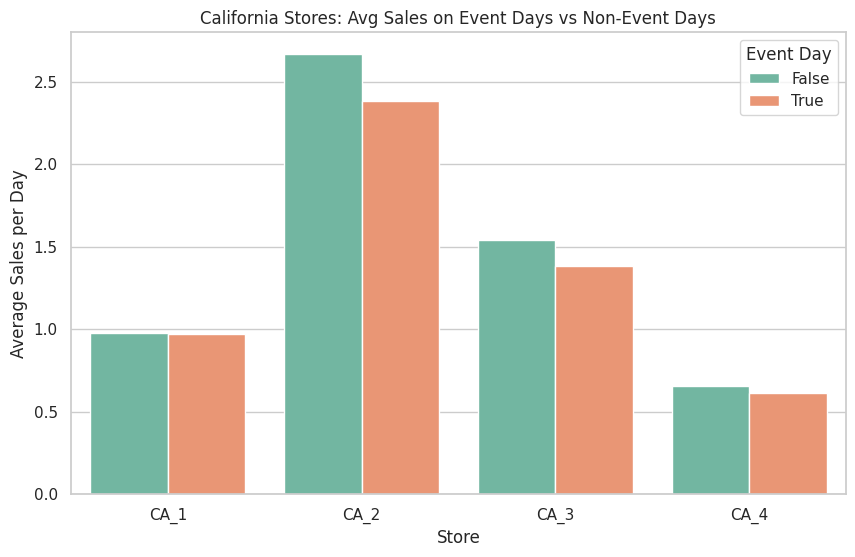

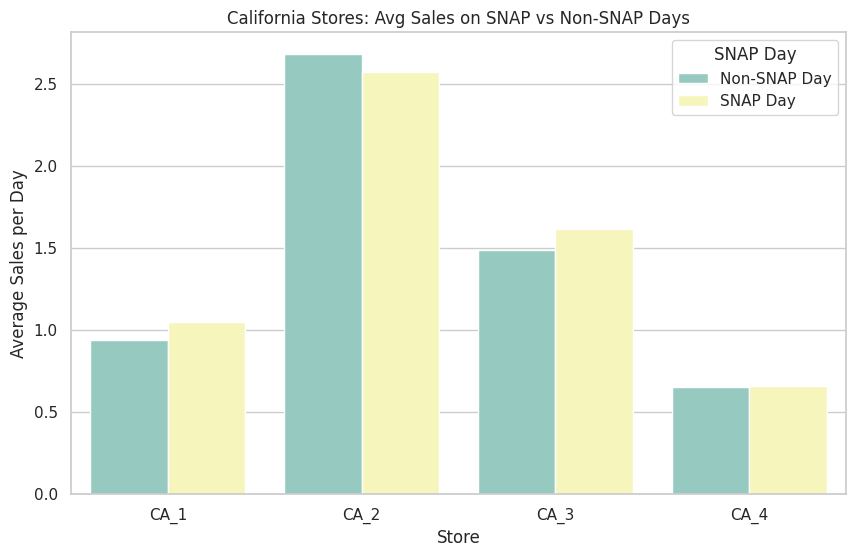

In [55]:
# ================================
# California Stores: Events & SNAP Impact
# ================================

# 1️⃣ Filter sales for California stores only
ca_sales = sample_sales[sample_sales["store_id"].str.startswith("CA")].copy()

# Merge with calendar to get SNAP and Event info
# Ensure all necessary columns are brought in from calendar
# Remove suffixes as they are not needed if column names don't overlap
ca_sales = ca_sales.merge(calendar[["date", "event_name_1", "event_name_2", "snap_CA"]],
                          on="date",
                          how="left") # Removed suffixes
ca_sales = ca_sales.rename(columns={"event_name_1_x": "event_name_1"})

# Verify column names after merge
print("Columns after merge:", ca_sales.columns)

# -------------------------
# 2️⃣ Event vs Non-Event Sales
# -------------------------
# Create event_flag using the columns from the calendar merge
# Use the correct column names which were not suffixed
event_col1 = 'event_name_1'
event_col2 = 'event_name_2'

if event_col1 in ca_sales.columns and event_col2 in ca_sales.columns:
    ca_sales["event_flag"] = ca_sales[event_col1].notna() | ca_sales[event_col2].notna()

    event_sales = ca_sales.groupby(["store_id","event_flag"])["sales"].mean().reset_index()

    plt.figure(figsize=(10,6))
    sns.barplot(data=event_sales, x="store_id", y="sales", hue="event_flag", palette="Set2")
    plt.title("California Stores: Avg Sales on Event Days vs Non-Event Days")
    plt.ylabel("Average Sales per Day")
    plt.xlabel("Store")
    plt.legend(title="Event Day")
    plt.show()
else:
    print(f"Error: Expected event columns '{event_col1}' or '{event_col2}' not found after merge.")


# -------------------------
# 3️⃣ SNAP vs Non-SNAP Sales
# -------------------------
# Use the snap_CA column from the calendar merge
snap_col = 'snap_CA' # Use the correct column name

if snap_col in ca_sales.columns:
    snap_sales_ca = ca_sales.groupby(["store_id",snap_col])["sales"].mean().reset_index()
    snap_sales_ca.columns = ["store_id", "snap_CA", "sales"] # Rename column for clarity
    snap_sales_ca["snap_CA"] = snap_sales_ca["snap_CA"].map({0:"Non-SNAP Day",1:"SNAP Day"})

    plt.figure(figsize=(10,6))
    sns.barplot(data=snap_sales_ca, x="store_id", y="sales", hue="snap_CA", palette="Set3")
    plt.title("California Stores: Avg Sales on SNAP vs Non-SNAP Days")
    plt.ylabel("Average Sales per Day")
    plt.xlabel("Store")
    plt.legend(title="SNAP Day")
    plt.show()
else:
     print(f"Error: Expected SNAP column '{snap_col}' not found after merge.")

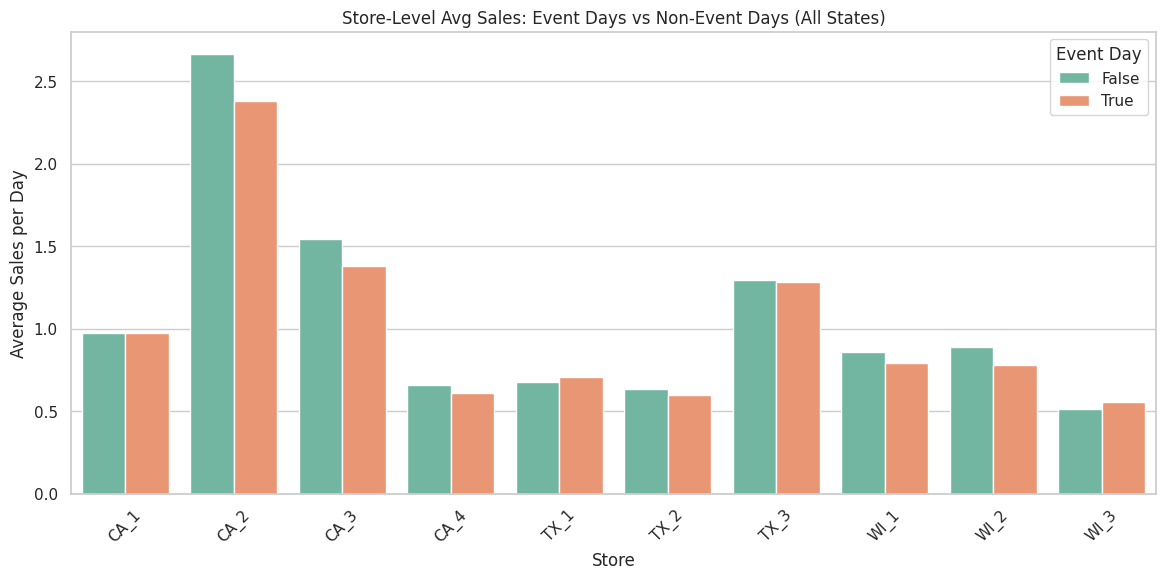

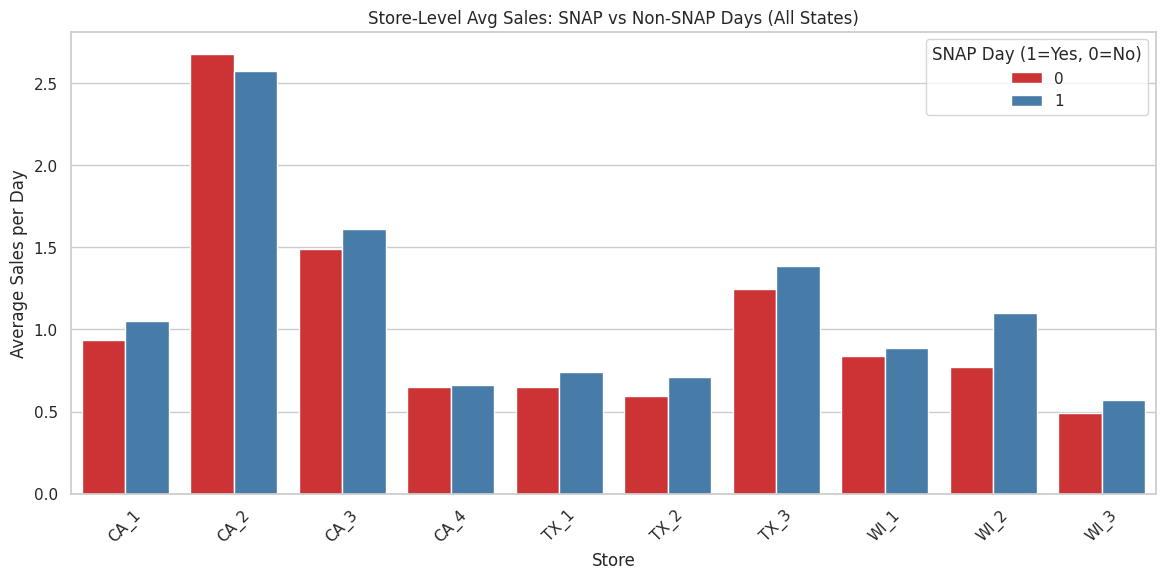

📊 Store-Level Sales Impact from Events & SNAP (All States):


,state_id,store_id,avg_sales,event_day_sales,snap_day_sales
0,CA,CA_1,0.974859,0.936324,1.050561
1,CA,CA_2,2.644184,0.936324,1.050561
2,CA,CA_3,1.529554,0.936324,1.050561
3,CA,CA_4,0.652795,0.936324,1.050561
4,TX,TX_1,0.679431,0.936324,1.050561
5,TX,TX_2,0.631706,0.936324,1.050561
6,TX,TX_3,1.294065,0.936324,1.050561
7,WI,WI_1,0.854927,0.936324,1.050561
8,WI,WI_2,0.878837,0.936324,1.050561
9,WI,WI_3,0.516155,0.936324,1.050561


In [57]:
# ================================
# Events & SNAP Impact: All States
# ================================

# 1️⃣ Merge sales with calendar (for all states)
# We'll include each state's SNAP column separately
merged_sales = sample_sales.merge(
    calendar[["date","event_name_1","event_name_2","snap_CA","snap_TX","snap_WI"]],
    on="date", how="left"
)

merged_sales = merged_sales.rename(columns={"event_name_1_x": "event_name_1"})

# 2️⃣ Create event flag
merged_sales["event_flag"] = merged_sales["event_name_1"].notna() | merged_sales["event_name_2"].notna()

# 3️⃣ Assign correct SNAP column based on state
def get_snap(row):
    if row["state_id"] == "CA":
        return row["snap_CA"]
    elif row["state_id"] == "TX":
        return row["snap_TX"]
    else:
        return row["snap_WI"]

merged_sales["snap_flag"] = merged_sales.apply(get_snap, axis=1)

# -------------------------
# 4️⃣ Event vs Non-Event Sales (per store)
# -------------------------
event_sales = merged_sales.groupby(["state_id","store_id","event_flag"])["sales"].mean().reset_index()

plt.figure(figsize=(14,6))
sns.barplot(data=event_sales, x="store_id", y="sales", hue="event_flag", palette="Set2")
plt.title("Store-Level Avg Sales: Event Days vs Non-Event Days (All States)")
plt.ylabel("Average Sales per Day")
plt.xlabel("Store")
plt.xticks(rotation=45)
plt.legend(title="Event Day")
plt.show()

# -------------------------
# 5️⃣ SNAP vs Non-SNAP Sales (per store)
# -------------------------
snap_sales = merged_sales.groupby(["state_id","store_id","snap_flag"])["sales"].mean().reset_index()

plt.figure(figsize=(14,6))
sns.barplot(data=snap_sales, x="store_id", y="sales", hue="snap_flag", palette="Set1")
plt.title("Store-Level Avg Sales: SNAP vs Non-SNAP Days (All States)")
plt.ylabel("Average Sales per Day")
plt.xlabel("Store")
plt.xticks(rotation=45)
plt.legend(title="SNAP Day (1=Yes, 0=No)")
plt.show()

# -------------------------
# 6️⃣ Combined Summary
# -------------------------
summary = merged_sales.groupby(["state_id","store_id"]).agg(
    avg_sales=("sales","mean"),
    event_day_sales=("sales", lambda x: merged_sales.loc[merged_sales["event_flag"],"sales"].mean()),
    snap_day_sales=("sales", lambda x: merged_sales.loc[merged_sales["snap_flag"]==1,"sales"].mean())
).reset_index()

print("📊 Store-Level Sales Impact from Events & SNAP (All States):")
display(summary.head(20))  # preview
